A typical NLP pipeline:
1. Data Acquistion
2. Text Cleaning e.g. spell checking with Bing Spell Check REST API and Python https://docs.microsoft.com/en-us/azure/cognitive-services/bing-spell-check/quickstarts/python
3. Pre-Processing e.g. remove special characters & digits, sentence segmentation, word tokenisation, lowercase, stop word removal, stemming, lemmatisation, POS tagging
4. Feature Engineering
5. Modeling
6. Evaluation
7. Deployment
8. Monitoring and Model Updating

In [1]:
import os
import pandas as pd
import numpy as np
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [77]:
home_path = os.path.expanduser("~")
plots_fp = '../plots'
os.makedirs(plots_fp, exist_ok=True)
fp = f'{home_path}/git/30-days-of-NLP/notebooks/Data/bbc-text.csv'
df = pd.read_csv(fp)

In [3]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
print(f'Number of documents in dataset: {len(df)}')

Number of documents in dataset: 2225


There are 5 classes in the dataset

In [5]:
df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

The number of examples in each class is:

Checking the proportions of classes is important to observe if there is any class imbalance

,text,prepro,prepro2
category,,,
business,510,510,510
entertainment,386,386,386
politics,417,417,417
sport,511,511,511
tech,401,401,401


sport            0.229663
business         0.229213
politics         0.187416
tech             0.180225
entertainment    0.173483
Name: category, dtype: float64

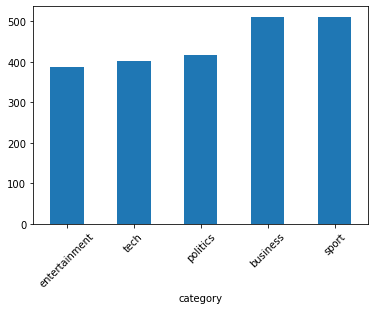

In [75]:
display(df.groupby('category').count())
display(df["category"].value_counts()/df.shape[0]) # Class distribution in the dataset
df.groupby('category').size().sort_values().plot.bar()
plt.xticks(rotation=45);

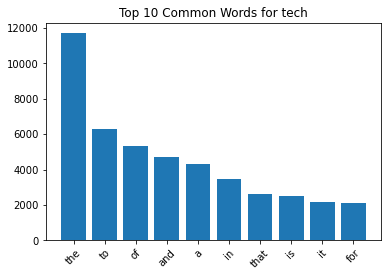

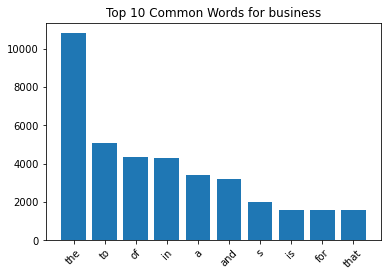

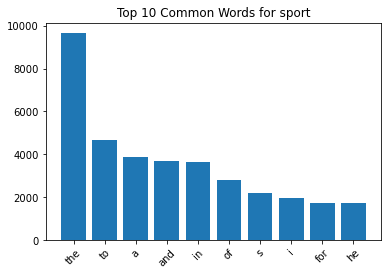

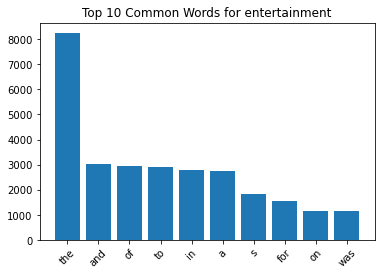

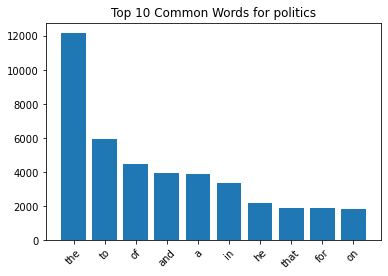

In [8]:
def plot_common_words(text, category):
    text_dict = dict(text)
    plt.bar(text_dict.keys(), text_dict.values())
    plt.title(f'Top 10 Common Words for {category}')
    plt.xticks(rotation=45)
    plt.show()

categories = df.groupby('category')
for category in df.category.unique():
    text = ' '.join(categories.get_group(category)['text'])
    common_words = Counter(text.split()).most_common(10)
    plot_common_words(common_words, category)

Let's look in the politics text to count the punctuation and digits

In [9]:
print(category)
# Are digits/punctuation?
regexp = re.compile('[^a-z A-Z]+') # ^ means not a-z or A-Z or ' ' important to include the space!
punc = [s for t in text for s in t if regexp.search(s)]
print(f'Number of non-character text: {len(punc)}')
Counter(punc)

politics
Number of non-character text: 18894


Counter({'.': 8852,
         '-': 2095,
         '4': 389,
         ':': 675,
         '£': 383,
         '3': 354,
         '5': 503,
         '1': 1027,
         '0': 1974,
         '7': 269,
         '2': 760,
         '6': 271,
         '8': 256,
         '%': 207,
         '9': 456,
         '[': 28,
         ']': 28,
         '(': 110,
         ')': 111,
         ';': 47,
         '$': 12,
         '/': 23,
         '&': 18,
         '#': 7,
         '!': 34,
         '+': 2,
         '=': 2,
         '`': 1})

There is a lot of full stops and numbers. Standard practice is to remove these. 

Note: examples such as “N.Y.” should be treated as a single word and not be tokenized. Such language-specific exceptions can be specified in the tokenizer provided by spaCy. Not implemented here but considered when analysising the results; the decisions we make in preprocessing can have consequences later in the pipeline. 

### Preprocessing
lowercase, remove stopwords, digits and punctunation. Return word tokenised data

In [10]:
from nltk.corpus import stopwords
import nltk
import string
def preprocess_corpus(texts):
    mystopwords = set(stopwords.words('english'))
    def remove_stops_digits(tokens):
        return[token.lower() for token in tokens if token not in mystopwords and 
               not token.isdigit() and token not in string.punctuation]
    return remove_stops_digits(nltk.word_tokenize(texts))

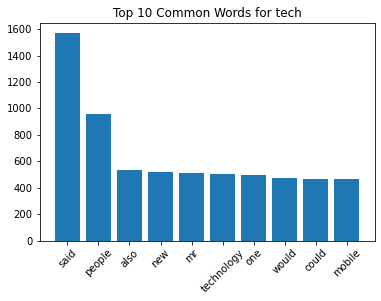

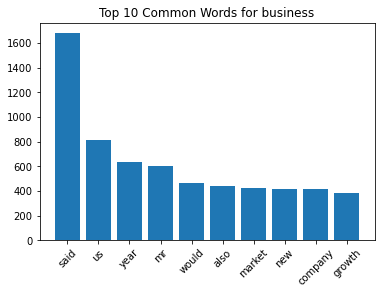

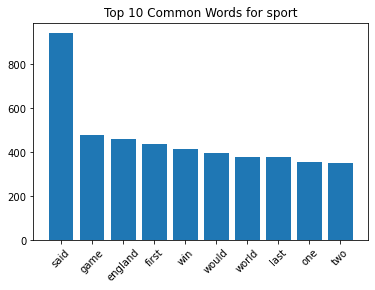

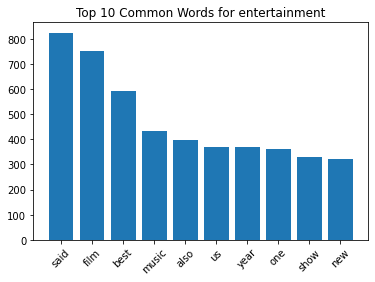

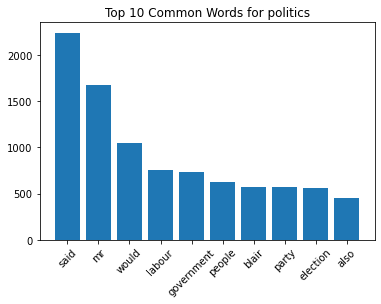

In [18]:
df['prepro'] = df['text'].apply(preprocess_corpus)

categories = df.groupby('category')
for category in df.category.unique():
    text_s = categories.get_group(category)['prepro']  # get the preprocessed data
    corpus = [''.join(j) for i in text_s for j in i]  # join all the tokenised text into one giant list
    common_words = Counter(corpus).most_common(10)  # count the top ten most common words
    plot_common_words(common_words, category)  

Is there any similar words in all 5 classes that we can remove?

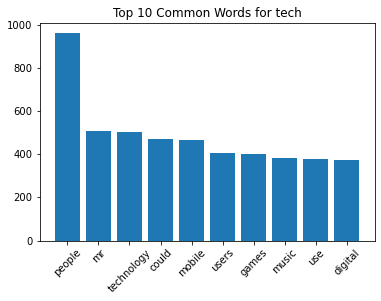

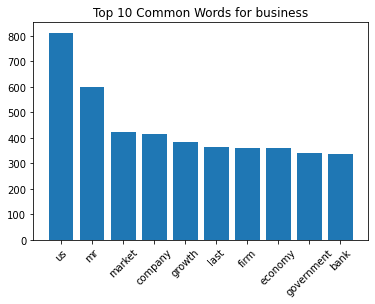

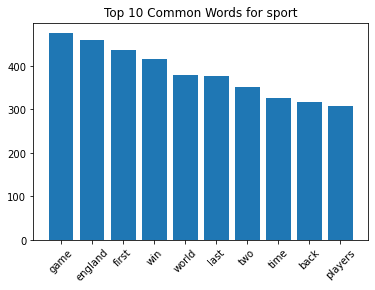

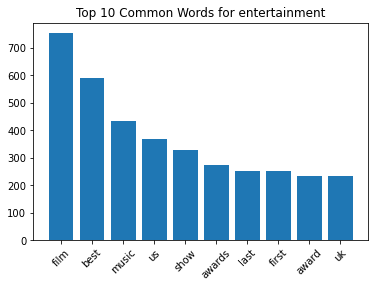

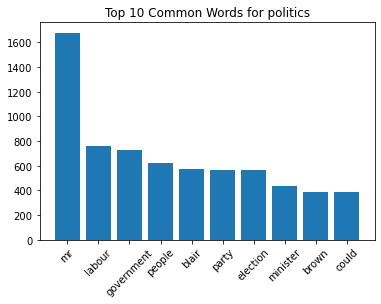

In [51]:
# Get the top common words in each category
all_common = []
for category in df.category.unique():
    text_s = categories.get_group(category)['prepro']  # get the preprocessed data
    corpus = [''.join(j) for i in text_s for j in i]  # join all the tokenised text into one giant list
    common_words = Counter(corpus).most_common(20)
    all_common.append(common_words)
    
# list of lists to one list with word (not counts) returned
flat_list = [item[0] for sublist in all_common for item in sublist]  
# count occurances of top 20 common words in each of the categories
count_d = Counter(flat_list)  
# identify word to remove if it appears in 4 or 5 of the categories 
remove_words = [i[0] for i in count_d.most_common() if i[1] > 3]

# remove words from the dataset
df['prepro2'] = df['prepro'].apply(lambda x: [item for item in x if item not in remove_words])

# plot results
for category in df.category.unique():
    text_s = categories.get_group(category)['prepro2']  # get the preprocessed data
    corpus = [''.join(j) for i in text_s for j in i]  # join all the tokenised text into one giant list
    common_words = Counter(corpus).most_common(10)  # count the top ten most common words
    plot_common_words(common_words, category)  

Plot wordcloud from the first row of text in the dataframe

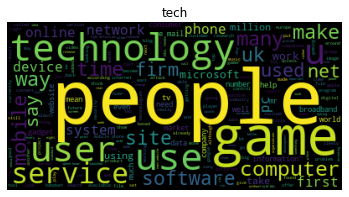

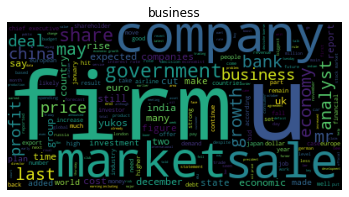

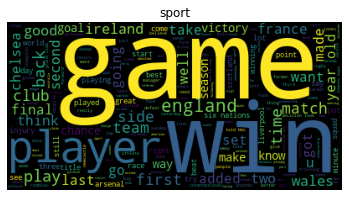

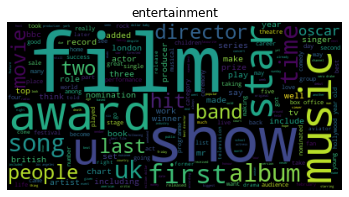

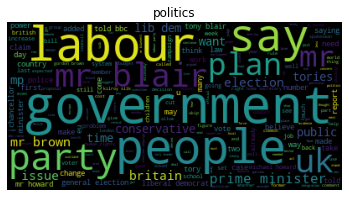

In [78]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.savefig(f'{plots_fp}/{title}.png')
    plt.show()

for category in df.category.unique():
    text_s = categories.get_group(category)['prepro2']
    corpus = ' '.join([' '.join(i) for i in text_s])
    plot_wordcloud(corpus, category)
    

#### Stemming and Lemmatisation

### TF-IDF
Term Frequency — Inverse Document Frequency

"This is a technique to quantify a word in documents, we generally compute a weight to each word which signifies the importance of the word in the document and corpus. This method is a widely used technique in Information Retrieval and Text Mining" (source: https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089)